In [1]:
from os import sys
sys.path.append("..")

# ODE Solver

The following code demonstrates how to solve first and second order ODE's using my software.

# First Order

To solve a first order ODE of the form $\frac{dx}{dt} = x$ it must first be written as a python funtion as follows:


In [2]:
import numpy as np

def f(x, t):
    """
    Returns an array with one element.

    Parameters
    ----------
    x : float
        The value of x.
    t : float
        The time the solution must be evaluated at.

    Returns
    -------
    x : numpy.ndarray
        An array containing the value of x.
    """
    return np.array([x])


Now the ODE can be solved using custom ODE solver. Within this solver it is possible to specify a particular solving method from Euler's method, Runge-Kutta 4th order and Heun 3rd order. The initial condition x0 at time t=0 must also be specified, alongside the start and end times and the step-size the solver is to take. Finally, it should be specified whether it is a first or second order ODE: 'True' if it is a system of equations, otherwise 'False'. In this example, Euler's method will be used.

In [3]:
import matplotlib.pyplot as plt
import math
import numpy as np
from ODE import solve_ode

method = 'euler'
f_euler, f_time = solve_ode(f, 1, 0, 1, method, 0.01, False)

To verify the numerical solution it can now be plotted against the true solution which is known to be:

$x(t)=e^t$

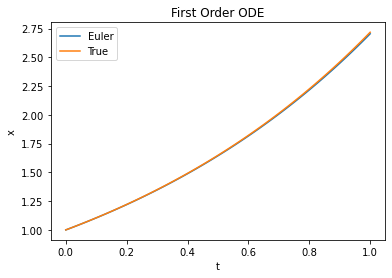

In [4]:
def f_true_solution(t):
    """
    Returns the true solution of the first order ODE dx/dt = x.

    Parameters
    ----------
    t : numpy.ndarray
        An array containing the times the solution must be evaluated at.

    Returns
    -------
    numpy.ndarray
        An array containing the true solution of the first order ODE dx/dt = x.
    """
    return np.exp(t)

plt.plot(f_time, f_euler, label='Euler')
plt.plot(f_time, f_true_solution(f_time), label='True')

plt.xlabel('t')
plt.ylabel('x')
plt.title('First Order ODE')
plt.legend()


# Higher Order ODEs

To solve higher order ODEs it is necessary to first convert the ODE into a system of first order ODEs. For example, the second order ODE $\ddot{x} = -x$, can be written as $\dot{x} = y$ and $\dot{y} = -x$. This is coded as a function to be passed to solve_ode as follows:

In [5]:
def f_ddot(u, t):
    x, y = u
    return np.array([y, -x])

This can now be passed to solve_ode. I will demonstrate the solution using Runge-Kutta 4th Order solver this time. It should be noted that the parameter distinguishing between system of ODEs is now set to 'True'.


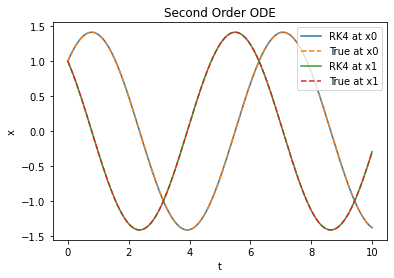

In [6]:
method = 'RK4'
ddot_rk4, ddot_time = solve_ode(f_ddot, [1, 1], 0, 10, method, 0.01, True)

#Verify numerical solution against analytical.

def f_ddot_true_solution(t):
    x = np.cos(t) + np.sin(t)
    y = np.cos(t) - np.sin(t)
    u = [x, y]
    return u

# RK4 and True solutions to the first initial condition
plt.plot(ddot_time, ddot_rk4[:, 0], label='RK4 at x0')
plt.plot(ddot_time, f_ddot_true_solution(ddot_time)[0], label='True at x0',linestyle='--')

plt.plot(ddot_time, ddot_rk4[:, 1], label='RK4 at x1')
plt.plot(ddot_time, f_ddot_true_solution(ddot_time)[1], label='True at x1',linestyle='--')

plt.xlabel('t')
plt.ylabel('x')
plt.title('Second Order ODE')
plt.legend()

# Error Evaluation

To Evaluate the performance of the three different Numerical solvers I have implemented, a function calculating the error between the numerical and analytical solutions at varying timesteps has been created.


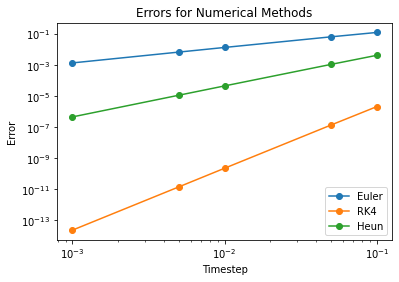

In [8]:
from ODE import plot_error
from ODE_PDE_funcs import f, f_true_solution

plot_error(f,f_true_solution)

The above plot clearly demonstrates the superiority of the Runge-Kutta 4th order method, with the smallest error over a range of timesteps. 